<a href="https://colab.research.google.com/github/remanx2558/MIDBReviews/blob/master/ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


"""
ELMo is a deep contextualized word representation that models both 
(1) complex characteristics of word use (e.g., syntax and semantics), and 
(2) how these uses vary across linguistic contexts (i.e., to model polysemy). 
These word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus.
 They can be easily added to existing models and significantly improve the state of the art across a broad range of challenging NLP problems, 
 including question answering, textual entailment and sentiment analysis.
"""


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Article -13


1) Requirements:

In [0]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15
#requirements

     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 512kB 44.6MB/s 
     |████████████████████████████████| 3.8MB 33.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e6b33888449205328a903feb68d3e51f073b73c3ca0307e777251adfc17dd887
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: 

     |████████████████████████████████| 9.1MB 3.2MB/s 


In [0]:
# load packages
from sklearn import metrics,preprocessing,model_selection
from sklearn.metrics import accuracy_score
import keras
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
spacy.load('en')
parser = English()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# get elmo from tensorflow hub
import tensorflow_hub as hub
import tensorflow as tf


In [0]:
embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)



In [0]:
# ELMo Embedding
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


2) DATA-Cleaning

In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Stop words and special characters 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [0]:
# Data Cleaner and tokenizer
def tokenizeText(text):
    
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    
    tokens = parser(text)
    
    # lemmatization
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # reomve stop words and special charaters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    tokens = list(set(tokens))
    
    return ' '.join(tokens[:])

3) Label-Encoding

In [0]:
#one -hot encoding
def encode(le_enc, labels):
    enc = le_enc.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le_enc, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le_enc.inverse_transform(dec)



4) Fetching DATA-SET

In [0]:


# load the dataset
trainDF_Sheet_1 = pd.read_csv(r"/content/drive/My Drive/malia/train.csv",encoding='latin-1')
trainDF_Sheet_1.isnull().values.any()
trainDF_Sheet_1.sentiment= trainDF_Sheet_1.sentiment.fillna(0.0).astype(int)#this will conver float into int and also manage missing values



In [0]:
trainDF_Sheet_1.head(10)

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0
3,It's a strange feeling to sit alone in a theat...,0
4,"You probably all already know this by now, but...",0
5,I saw the movie with two grown children. Altho...,0
6,You're using the IMDb. You've given some heft...,0
7,This was a good film with a powerful message o...,0
8,"Made after QUARTET was, TRIO continued the qua...",0
9,"For a mature man, to admit that he shed a tear...",0


In [0]:
trainDF_Sheet_1.shape

(25005, 2)

In [0]:
trainDF_Sheet_1['sentiment'].unique()

array([0, 1])

In [0]:
trainDF_Sheet_1['sentiment'].value_counts()

0    12505
1    12500
Name: sentiment, dtype: int64

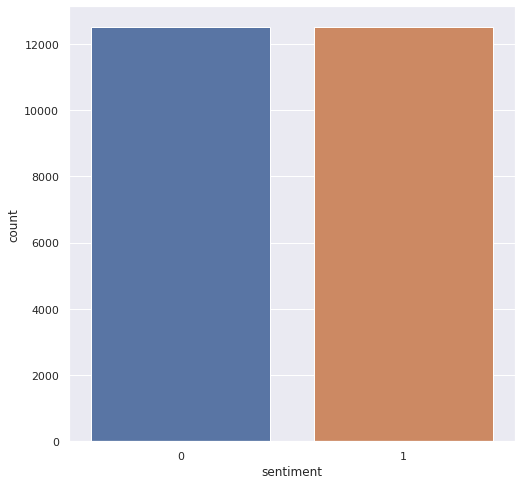

In [0]:
sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(trainDF_Sheet_1['sentiment'])

In [0]:
# Data cleaning
trainDF_Sheet_1['response_text'] = trainDF_Sheet_1['text'].apply(lambda x:tokenizeText(x))

In [0]:
# Data preparation
X = trainDF_Sheet_1['response_text'].tolist()
y = trainDF_Sheet_1['sentiment'].tolist()

# Lebel encoding
le_enc = preprocessing.LabelEncoder()
le_enc.fit(y)

y_en = encode(le_enc, y)

In [0]:
# split the dataset into training and testing datasets
x_train, x_test, y_train, y_test = model_selection.train_test_split(np.asarray(X), np.asarray(y_en), test_size=0.2, random_state=42)


In [0]:
x_train.shape



(20004,)

In [0]:
# Build Model
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=3, batch_size=16)
    model.save_weights('./response-elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./response-elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=16)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/3
20004/20004 [==============================] - 2607s 130ms/step - loss: 0.4997 - accuracy: 0.7574
Epoch 2/3
20004/20004 [==============================] - 2468s 123ms/step - loss: 0.4437 - accuracy: 0.7968
Epoch 3/3
20004/20004 [==============================] - 2462s 123ms/step - loss: 0.4291 - accuracy: 0.8026


In [0]:
# decode test labels
y_test = decode(le_enc, y_test)
# decode predicted labels
y_preds = decode(le_enc, predicts)

In [0]:
print(metrics.confusion_matrix(y_test, y_preds))

[[2048  497]
 [ 406 2050]]


In [0]:


print(metrics.classification_report(y_test, y_preds))



              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2545
           1       0.80      0.83      0.82      2456

    accuracy                           0.82      5001
   macro avg       0.82      0.82      0.82      5001
weighted avg       0.82      0.82      0.82      5001



In [0]:
print("Accuracy of ELMO is:",accuracy_score(y_test,y_preds))

Accuracy of ELMO is: 0.8194361127774445
